In [3]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.4.1+cu121


## Utility functions

In [4]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, xf_pflow, logpx_pflow

def compute_likelihoods2(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return x0_tests, xf_sde, xf_pflow, logpx_pflow


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, b_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    axes[0].plot(epochs, data_dict['b_losses'], label="b")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[2].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[2].set_xlim(-5,5)
    axes[2].set_ylim(-6.5,6.5)
    axes[2].set_title("Samples from PFlow", fontsize=14)


    # plot likelihood estimates.
    axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    axes[3].set_title(r"$\log p$ from PFlow")
    axes[3].legend(loc='best')
    axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b  : Any,
    opt_s  : Any,
    sched_b: Any, 
    sched_s: Any,
):
    """
    Take a single step of optimization on the training set.
    """
    opt_b.zero_grad()
    opt_s.zero_grad()


    # construct batch
    x0s = base(bs)
    x0s = x0s[torch.argsort(((x0s-x0s.mean(0))**2).sum(1))]
    x1s = target(bs)
    # x1s = x1s[torch.argsort(((x1s-x1s.mean(0))**2).sum(1))]
    ts  = torch.rand(size=(bs,))


    # compute the loss
    loss_start = time.perf_counter()
    loss_b     = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_s     = loss_fn_s(s, x0s, x1s, ts, interpolant)
    loss_val   = loss_b + loss_s
    loss_end   = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_s.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt_b.step()
    opt_s.step()
    sched_b.step()
    sched_s.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_val.detach(), loss_b.detach(), loss_s.detach(), b_grad.detach(), s_grad.detach()

### Define target

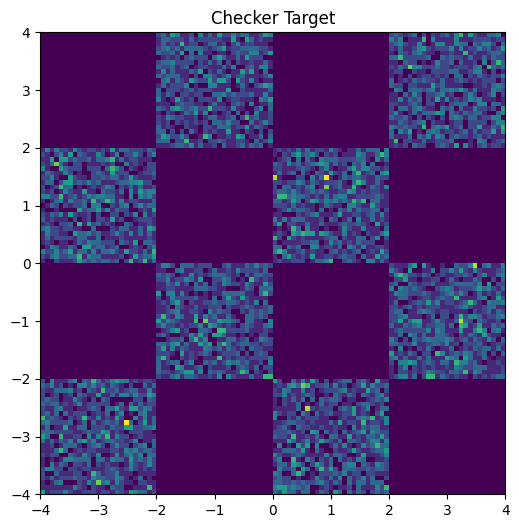

Batch Shape: (10000, 2)


In [5]:

ndim = 2
def target(bs):
    x1 = torch.rand(bs) * 4 - 2
    x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [6]:
base_loc     = torch.zeros(ndim)
base_var     = torch.ones(ndim)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(base(20000))

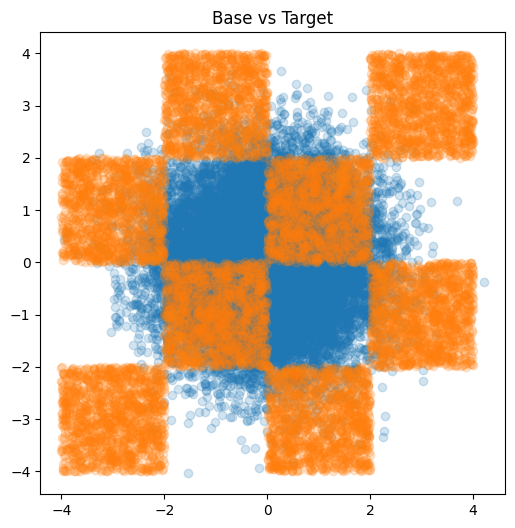

In [7]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A one sided interpolant, meaning that $x_0 \sim N(0,1)$

In [8]:
# gamma_type = 'brownian'
path = 'one-sided-linear'
interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

### Define losses for b and s

In [9]:
loss_fn_b = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-b')
loss_fn_s = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-s')

### Define velocity field and optimizers

In [42]:
base_lr      = 2e-3
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


b       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
s       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_b   = torch.optim.Adam(b.parameters(), lr=base_lr)
opt_s   = torch.optim.Adam(s.parameters(), lr=base_lr)
sched_b = torch.optim.lr_scheduler.StepLR(optimizer=opt_b, step_size=1500, gamma=0.4)
sched_s = torch.optim.lr_scheduler.StepLR(optimizer=opt_s, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 14
N_epoch      = 500
plot_bs      = 5000  # number of samples to use when plotting
bs           = 2000    # number of samples from rho_0 in batch
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]


if print_model:
    print("Here's the model b, s:", b, s)

[Loss: 0.018840912998712156], [Backprop: 0.023425494000548497], [Update: 0.013528650997614022].
EPOCH: 1
LOSS, GRAD: tensor(0.0318) tensor([1.2750]) tensor([1.6769])


/tmp/ipykernel_145115/215068034.py:145: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  axes[1].scatter(


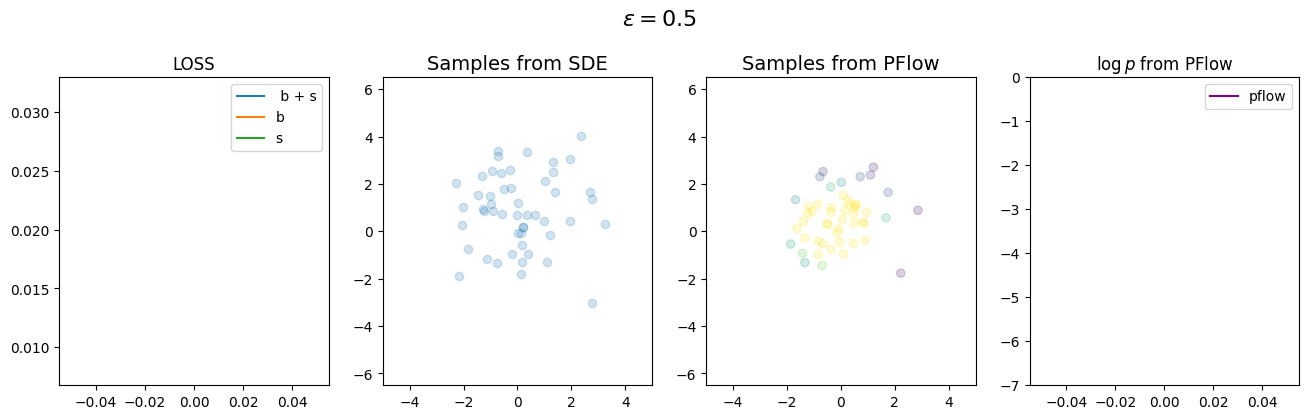

[Loss: 0.021079096004541498], [Backprop: 0.01831123499869136], [Update: 0.003970619000028819].
[Loss: 0.017694950998702552], [Backprop: 0.02290441900549922], [Update: 0.007532693001849111].
[Loss: 0.01788652300456306], [Backprop: 0.0202548309971462], [Update: 0.010911850004049484].
EPOCH: 501
LOSS, GRAD: tensor(-3.2904) tensor([4.4722]) tensor([3.3385])


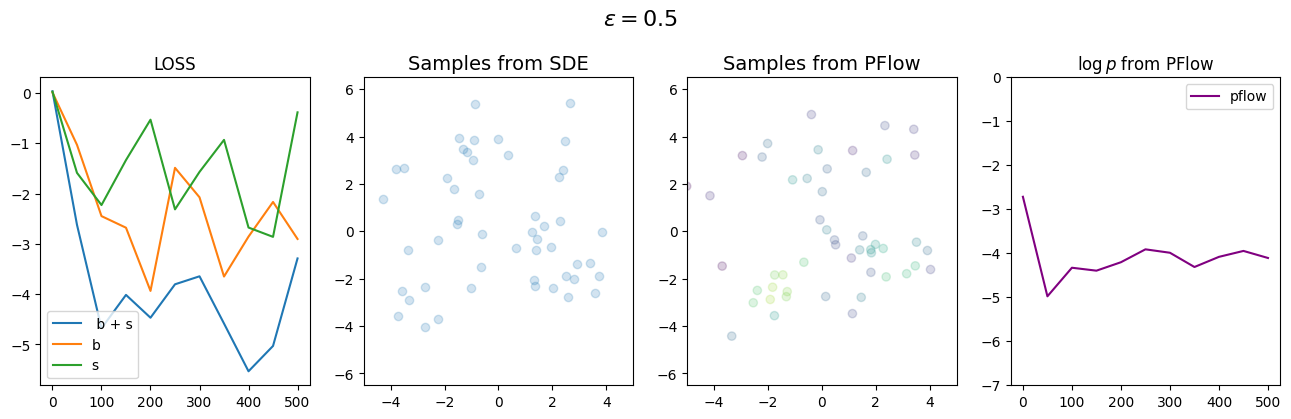

EPOCH: 1001
LOSS, GRAD: tensor(-4.3267) tensor([3.5372]) tensor([7.3070])


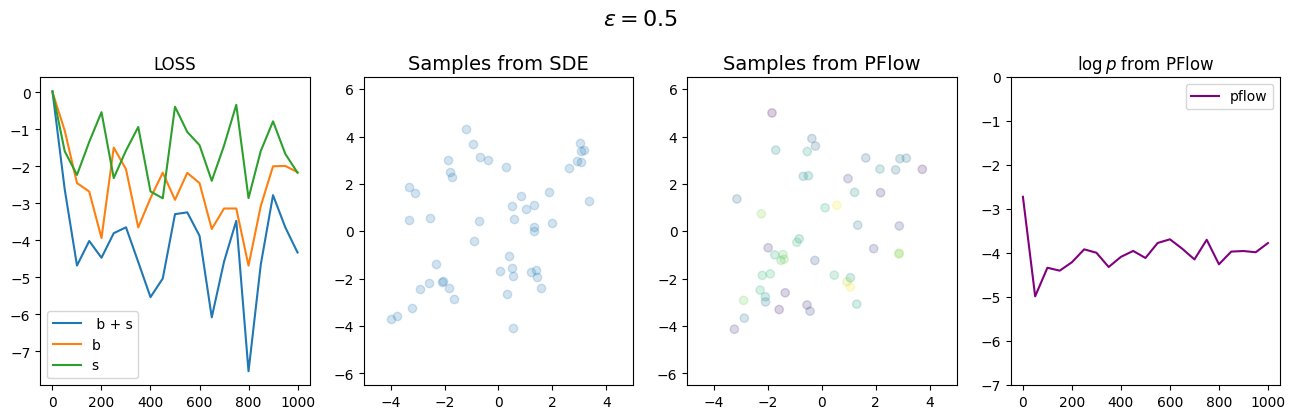

EPOCH: 1501
LOSS, GRAD: tensor(-8.2349) tensor([3.0512]) tensor([11.1795])


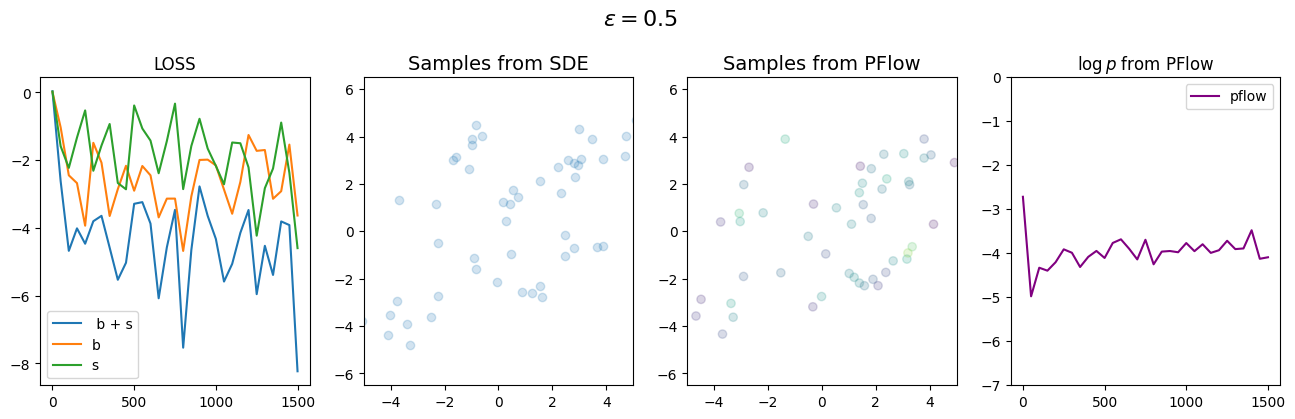

EPOCH: 2001
LOSS, GRAD: tensor(-8.6678) tensor([4.3517]) tensor([21.4677])


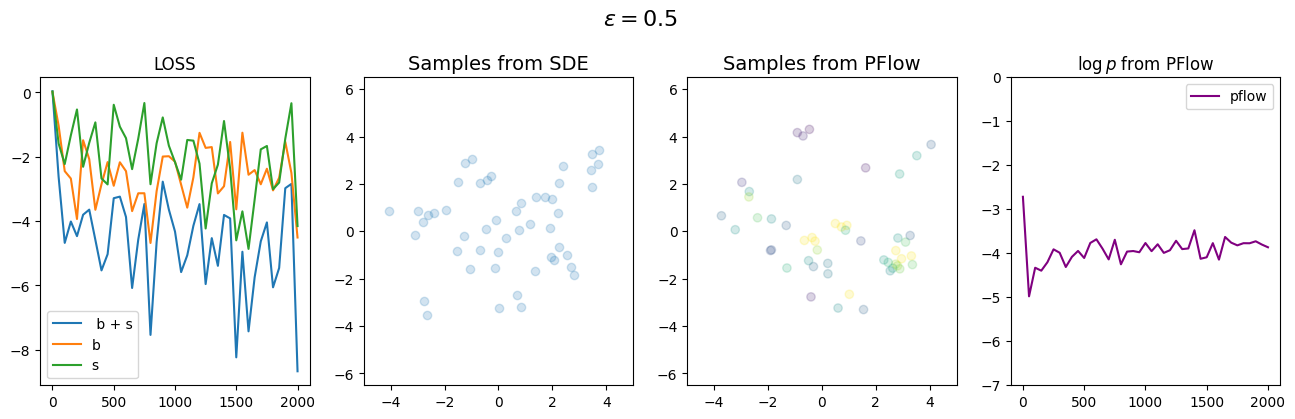

EPOCH: 2501
LOSS, GRAD: tensor(-6.8978) tensor([4.3669]) tensor([29.0506])


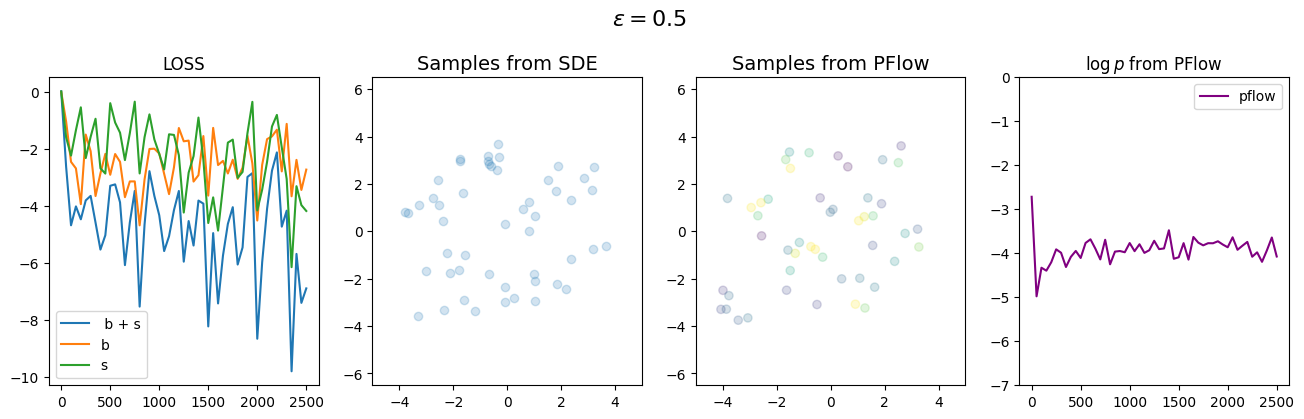

EPOCH: 3001
LOSS, GRAD: tensor(-4.8609) tensor([3.4169]) tensor([13.8164])


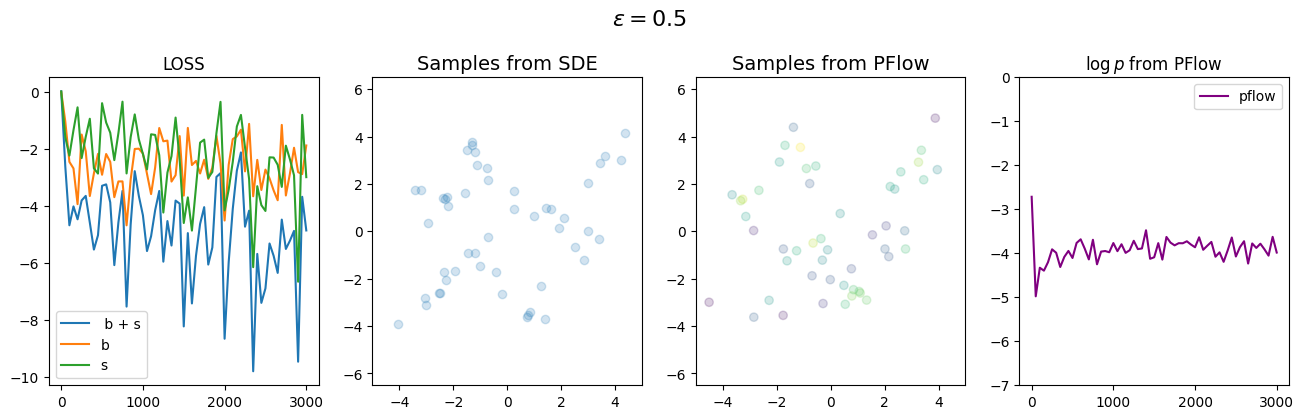

EPOCH: 3501
LOSS, GRAD: tensor(-3.1105) tensor([4.0211]) tensor([18.9193])


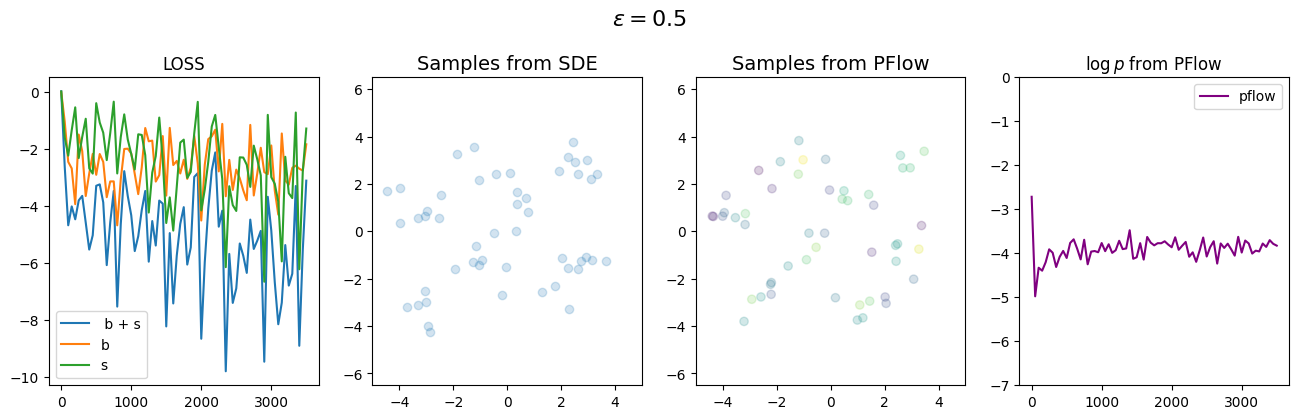

EPOCH: 4001
LOSS, GRAD: tensor(-5.5679) tensor([3.8929]) tensor([41.0510])


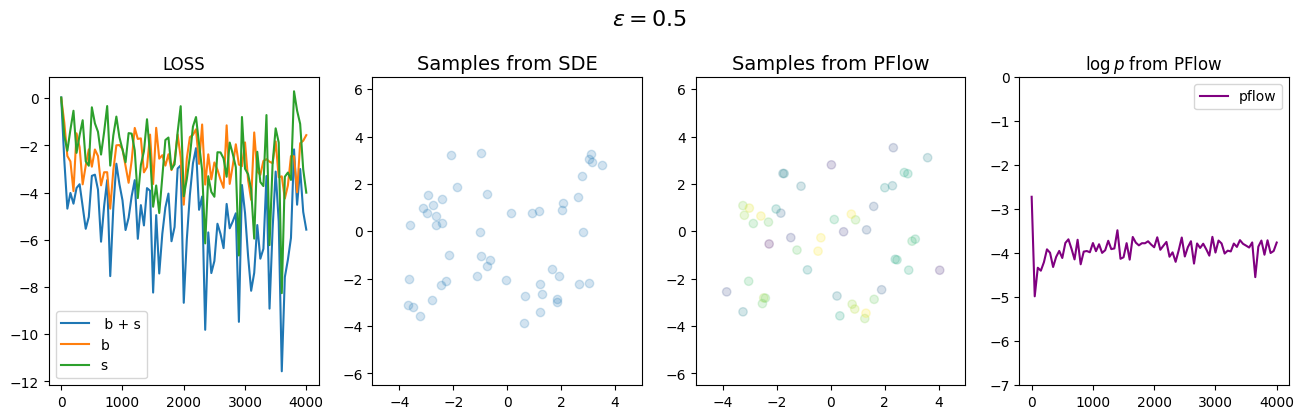

EPOCH: 4501
LOSS, GRAD: tensor(-7.0890) tensor([3.7899]) tensor([19.8287])


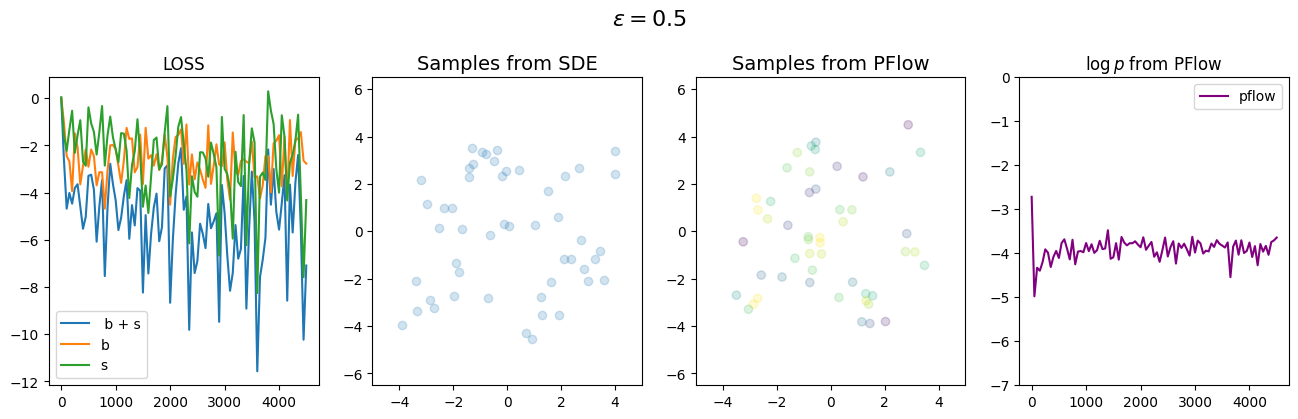

EPOCH: 5001
LOSS, GRAD: tensor(-9.9698) tensor([3.0704]) tensor([15.8363])


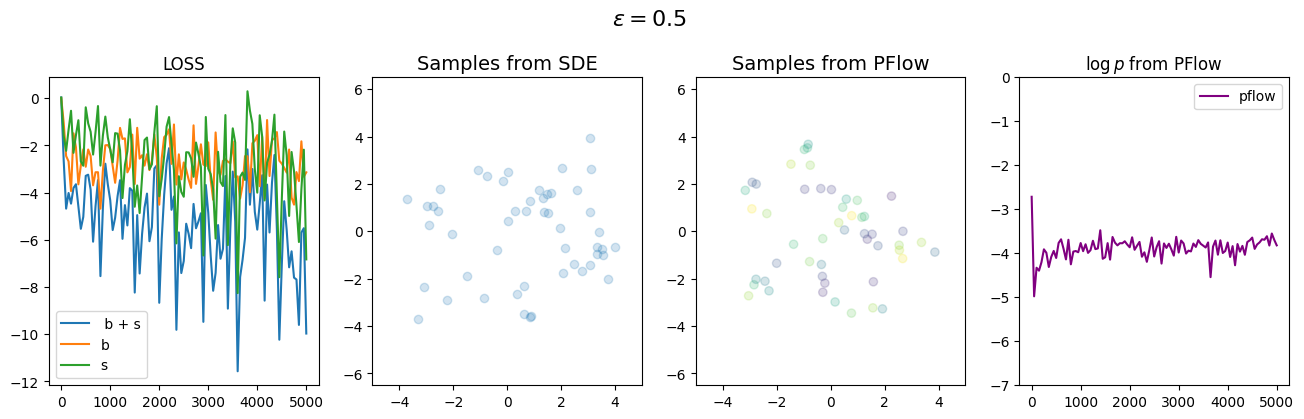

EPOCH: 5501
LOSS, GRAD: tensor(-3.2557) tensor([4.3840]) tensor([13.7163])


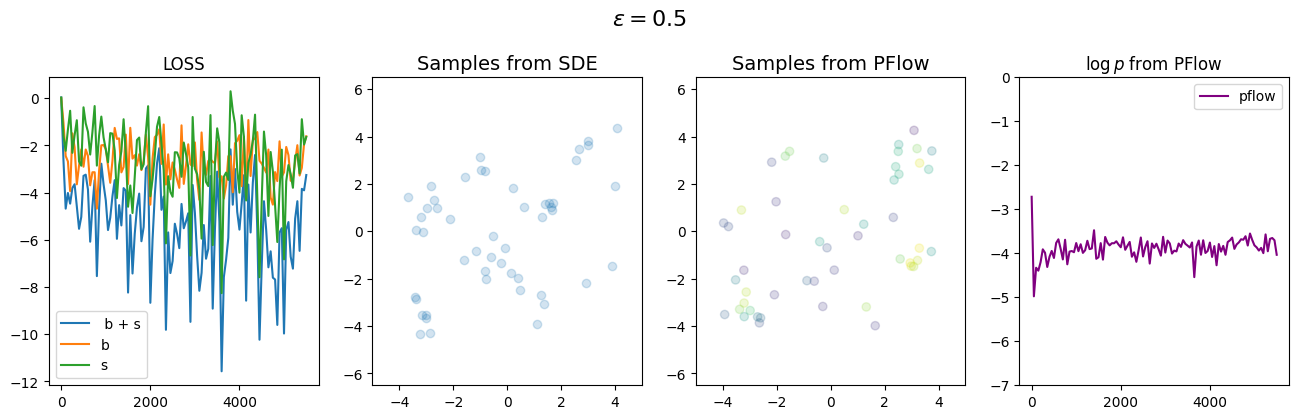

EPOCH: 6001
LOSS, GRAD: tensor(-5.8877) tensor([3.7903]) tensor([17.4510])


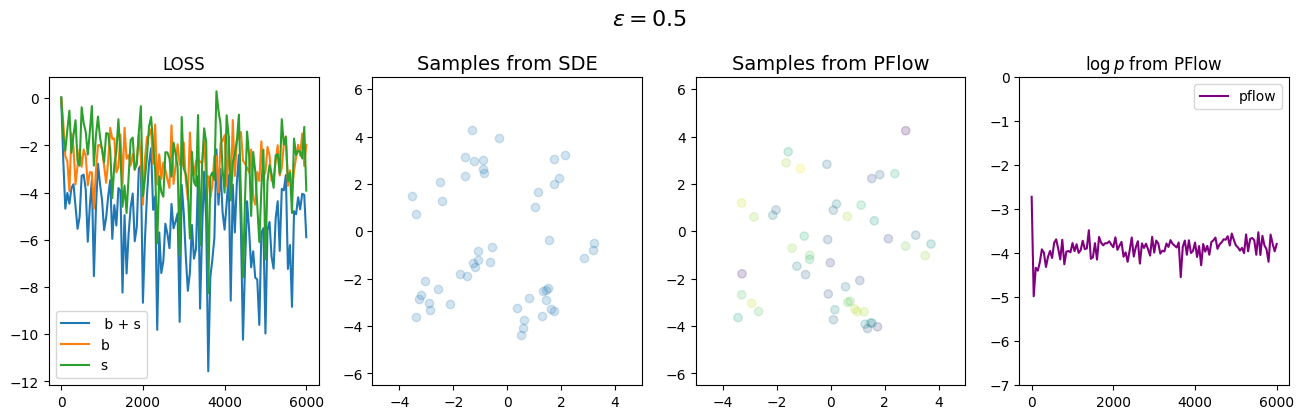

EPOCH: 6501
LOSS, GRAD: tensor(-6.7421) tensor([5.8666]) tensor([26.9475])


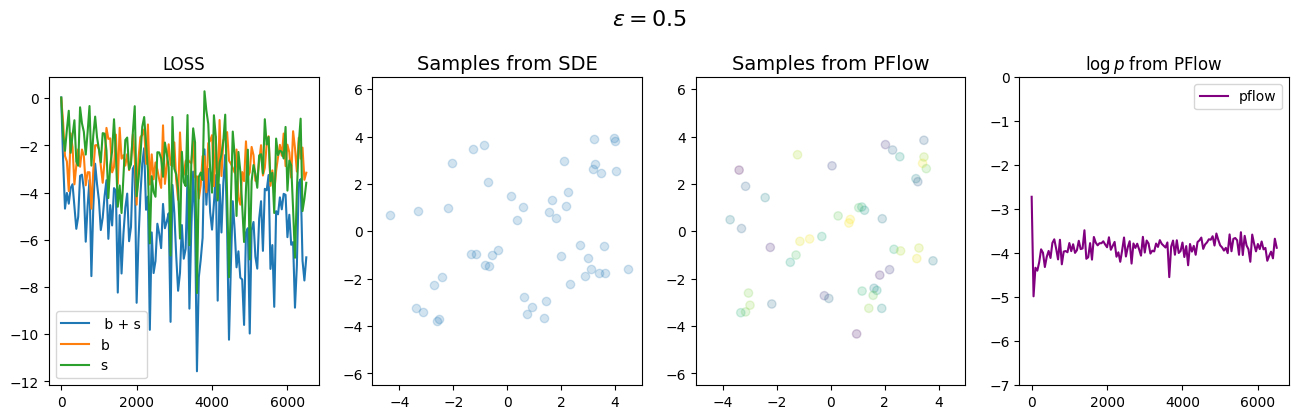

In [43]:
data_dict = {
    'losses': [],
    'b_losses': [],
    's_losses': [],
    'b_grads': [],
    's_grads': [],
    'times': [],
    'logps_pflow': [],
}

counter = 1
for i, era in enumerate(range(N_era)):
    for j, epoch in enumerate(range(N_epoch)):
        loss, b_loss, s_loss, b_grad, s_grad = train_step(bs, interpolant, opt_b, opt_s, sched_b, sched_s,
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(b, s, interpolant, n_save, n_step, bs, b_loss, 
                        s_loss, loss, b_grad, s_grad, eps, data_dict)


        if (counter - 1) % plot_freq == 0:
            make_plots(b, s, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, eps, data_dict)


        counter+=1

In [34]:
x0_tests, xf_sde, xf_pflow, logpx_pflow = compute_likelihoods2(b, s, interpolant, n_save, n_step, eps, bs)

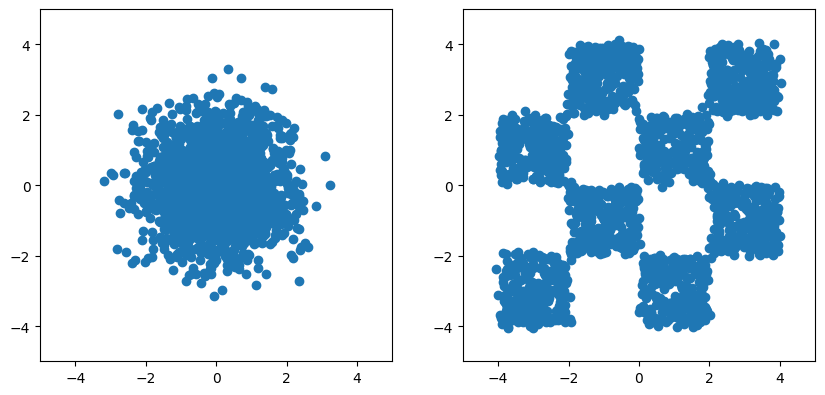

In [15]:
plt.subplots(1, 2, figsize=(10,6))
plt.subplot(1, 2, 1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect(1)
plt.scatter(*x0_tests.cpu().T)
plt.subplot(1, 2, 2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect(1)
plt.scatter(*xf_sde.T)
# plt.show()

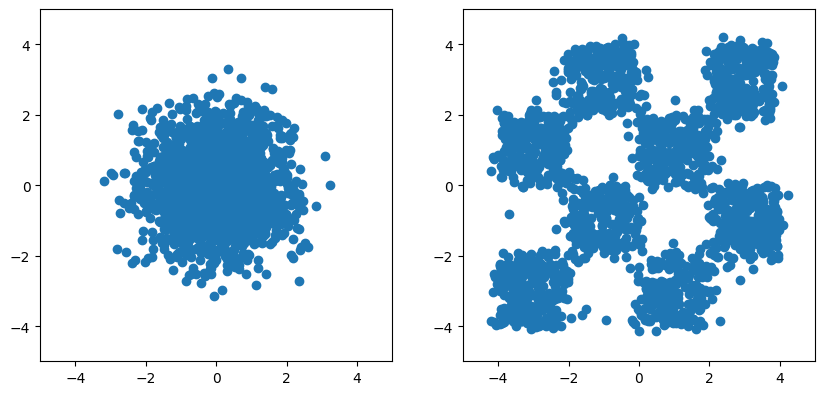

In [16]:
plt.subplots(1, 2, figsize=(10,6))
plt.subplot(1, 2, 1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect(1)
plt.scatter(*x0_tests.cpu().T)
plt.subplot(1, 2, 2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect(1)
plt.scatter(*xf_pflow.T)
# plt.show()

In [35]:
idxs = np.arange(len(xf_sde))

In [36]:
grid_idxs = np.searchsorted(np.arange(-4, 4+1, 2), xf_pflow)

In [37]:
leave_in_idxs = idxs[(grid_idxs>0).all(1)*(grid_idxs<5).all(1)*(grid_idxs.sum(1)%2==0)]

In [38]:
leave_out_idxs = np.array(list(set(idxs)-set(leave_in_idxs)))

In [39]:
identifier = (np.unique(grid_idxs[leave_in_idxs], axis=0)-1)[:,0]*4+(np.unique(grid_idxs[leave_in_idxs], axis=0)-1)[:,1]

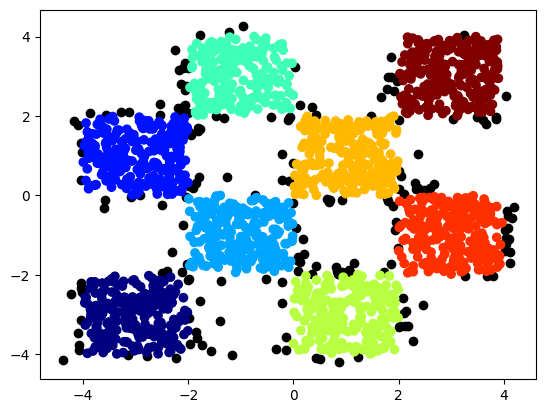

In [40]:
plt.scatter(*xf_pflow[leave_out_idxs].T, c="k")
plt.scatter(*xf_pflow[leave_in_idxs].T, c=np.searchsorted(identifier, (grid_idxs[leave_in_idxs][:,0]-1)*4+grid_idxs[leave_in_idxs][:,1]-1), cmap="jet", vmin=0, vmax=7)

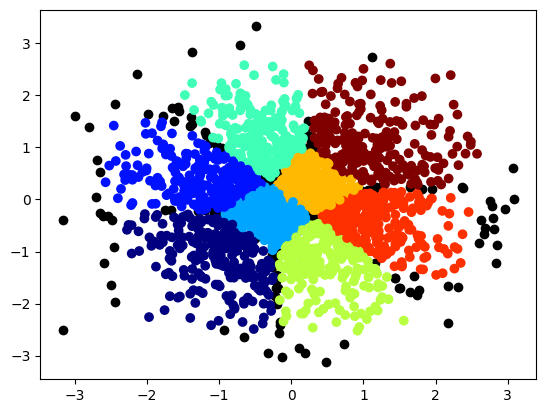

In [41]:
plt.scatter(*x0_tests.cpu()[leave_out_idxs].T, c="k")
plt.scatter(*x0_tests.cpu()[leave_in_idxs].T, c=np.searchsorted(identifier, (grid_idxs[leave_in_idxs][:,0]-1)*4+grid_idxs[leave_in_idxs][:,1]-1), cmap="jet")

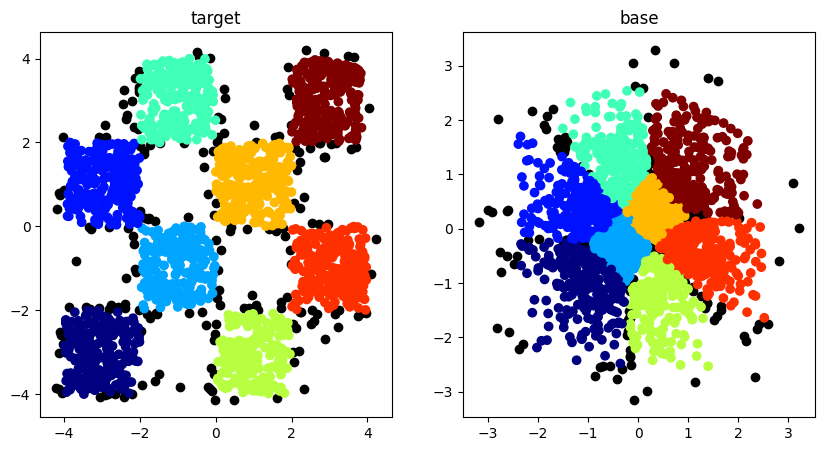

In [33]:
plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(*xf_pflow[leave_out_idxs].T, c="k")
plt.scatter(*xf_pflow[leave_in_idxs].T, c=np.searchsorted(identifier, (grid_idxs[leave_in_idxs][:,0]-1)*4+grid_idxs[leave_in_idxs][:,1]-1), cmap="jet", vmin=0, vmax=7)
plt.title("target")
plt.subplot(1, 2, 2)
plt.scatter(*x0_tests.cpu()[leave_out_idxs].T, c="k")
plt.scatter(*x0_tests.cpu()[leave_in_idxs].T, c=np.searchsorted(identifier, (grid_idxs[leave_in_idxs][:,0]-1)*4+grid_idxs[leave_in_idxs][:,1]-1), cmap="jet")
plt.title("base")
plt.show()

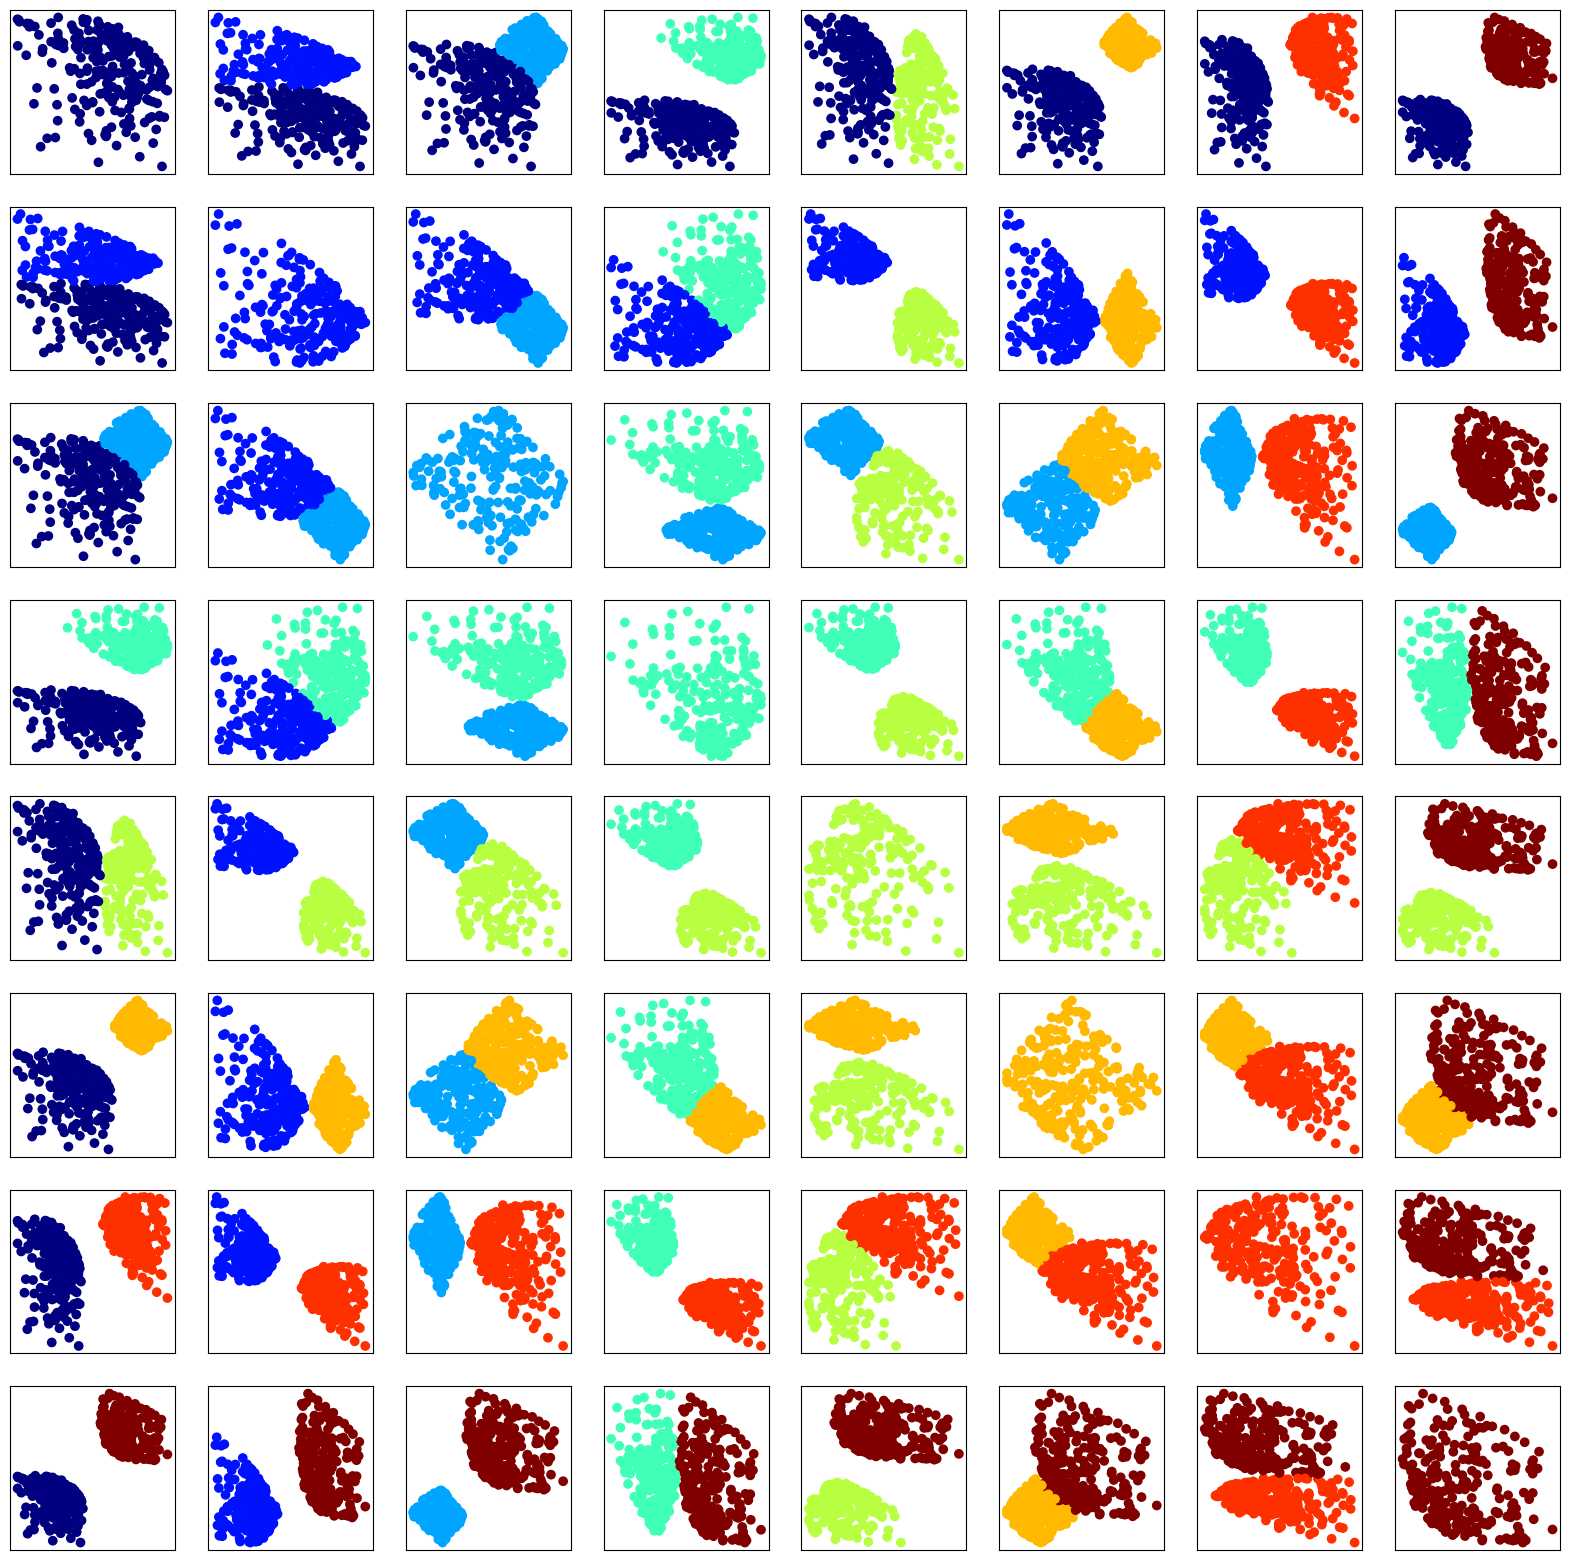

In [30]:
# plt.scatter(*x0_tests.cpu()[leave_out_idxs].T, c="k")
plt.subplots(8, 8, figsize=(20,20))
for i, pair1 in enumerate(np.unique(grid_idxs[leave_in_idxs], axis=0)):
    for j, pair2 in enumerate(np.unique(grid_idxs[leave_in_idxs], axis=0)):
        # if (pair1!=pair2).any():
            new_idxs = (grid_idxs[leave_in_idxs]==pair1).all(1)+(grid_idxs[leave_in_idxs]==pair2).all(1)
            plt.subplot(8, 8, i*8+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.scatter(*x0_tests.cpu()[leave_in_idxs][new_idxs].T, c=np.searchsorted(identifier, (grid_idxs[leave_in_idxs][new_idxs][:,0]-1)*4+grid_idxs[leave_in_idxs][new_idxs][:,1]-1), cmap="jet", vmin=0, vmax=7)

In [365]:
logp = np.log(2*np.pi)+ 1/2*(x0_tests.cpu()**2).sum(1)

In [368]:
for i, pair1 in enumerate(np.unique(grid_idxs[leave_in_idxs], axis=0)):
    new_idxs = (grid_idxs[leave_in_idxs]==pair1).all(1)
    print(logp[leave_in_idxs][new_idxs].mean())

tensor(3.1798, device='cpu')
tensor(2.9711, device='cpu')
tensor(2.3722, device='cpu')
tensor(2.9210, device='cpu')
tensor(2.9121, device='cpu')
tensor(2.4154, device='cpu')
tensor(2.9043, device='cpu')
tensor(3.2202, device='cpu')


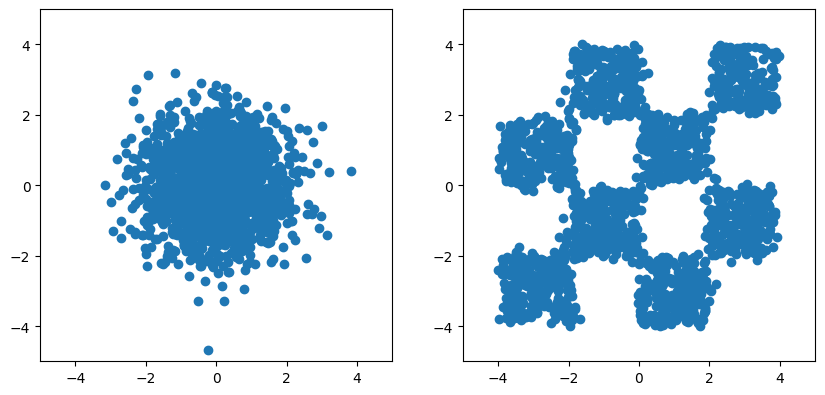

In [102]:
plt.subplots(1, 2, figsize=(10,6))
plt.subplot(1, 2, 1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect(1)
plt.scatter(*x0_tests.cpu()[idxs].T)
plt.subplot(1, 2, 2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect(1)
plt.scatter(*xf_sde[idxs].T)
# plt.show()